**5243 Project 3 Team 3**

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import Loss
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import time

#### Download

In [ ]:
!unzip data.zip

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`.

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset.

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


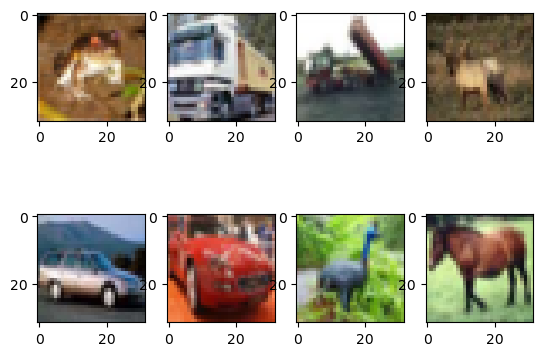

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))

## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

In [7]:
def create_cnn_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()

/Users/helena/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [8]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

# write your code here...

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    # Assuming the image is already normalized but you may need to adjust this depending on your input preprocessing
    image = image / 255.0
    image = np.expand_dims(image, axis=0)  # Expanding the dimensions to fit the model input
    predictions = cnn_model.predict(image)
    return np.argmax(predictions)  # Return the index of the highest probability class

In [9]:
noisy_labels_one_hot = to_categorical(noisy_labels, num_classes=10)

imgs_normalized = imgs / 255.0

In [10]:
# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(imgs_normalized, noisy_labels_one_hot, test_size=0.2, random_state=42)

# Create an instance of ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    rotation_range=20,       # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,   # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,    # randomly flip images horizontally
    zoom_range=0.2,          # randomly zoom image
)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

In [11]:
# Calculate class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(noisy_labels),
    y=noisy_labels.flatten()
)
class_weights_dict = dict(enumerate(class_weights))

In [12]:
# Fit the model
history_cnn = cnn_model.fit(X_train, y_train, 
                            batch_size=64,
                            epochs=10,
                            validation_data=(X_val, y_val),
                            class_weight=class_weights_dict
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - accuracy: 0.1151 - loss: 2.2969 - val_accuracy: 0.1796 - val_loss: 2.2563
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1788 - loss: 2.2468 - val_accuracy: 0.1976 - val_loss: 2.2341
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2079 - loss: 2.2214 - val_accuracy: 0.2119 - val_loss: 2.2225
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.2244 - loss: 2.1973 - val_accuracy: 0.2184 - val_loss: 2.2254
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2386 - loss: 2.1786 - val_accuracy: 0.2313 - val_loss: 2.2125
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.2526 - loss: 2.1566 - val_accuracy: 0.2373 - val_loss: 2.2158
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.2698 - loss: 2.1230 - val_accuracy: 0.2368 - val_loss: 2.2171
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.2872 - loss: 2.0832 - 

### 2.3. Model II

In [13]:
# [ADD WEAKLY SUPERVISED LEARNING FEATURE TO MODEL I]

# use Noise-Robust Loss function to cnn model
class SymmetricCrossEntropy(Loss):
    def __init__(self, alpha=1.0, beta=1.0, from_logits=False):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=self.from_logits)
        rce = tf.keras.losses.categorical_crossentropy(y_pred, y_true, from_logits=self.from_logits)
        return self.alpha * ce + self.beta * rce

def new_cnn_model_with():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=SymmetricCrossEntropy(alpha=1.0, beta=1.0),
                  metrics=['accuracy'])
    return model

new_cnn_model = new_cnn_model_with()

/Users/helena/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(imgs_normalized, noisy_labels_one_hot, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
datagen.fit(X_train)

In [15]:
# Initialize metrics and training phase
new_train_acc = []
new_val_acc = []
new_train_loss = []
new_val_loss = []

history_new_cnn = new_cnn_model.fit(datagen.flow(X_train, y_train, batch_size=64), validation_data=(X_val, y_val), epochs=10)

# Iterative training
iterations = 10
for iteration in range(iterations):
    predictions = new_cnn_model.predict(imgs)
    pseudo_labels = np.argmax(predictions, axis=1)

    confidence_threshold = 0.9
    high_confidence_indices = np.where(np.max(predictions, axis=1) > confidence_threshold)[0]

    X_train_augmented = np.concatenate([X_train, imgs_normalized[high_confidence_indices]], axis=0)
    y_train_augmented = np.concatenate([y_train, to_categorical(pseudo_labels[high_confidence_indices], num_classes=10)], axis=0)
    datagen.fit(X_train_augmented)

    history_new = new_cnn_model.fit(datagen.flow(X_train_augmented, y_train_augmented, batch_size=32), validation_data=(X_val, y_val), epochs=5)
    
    new_train_acc.extend(history_new.history['accuracy'])
    new_val_acc.extend(history_new.history['val_accuracy'])
    new_train_loss.extend(history_new.history['loss'])
    new_val_loss.extend(history_new.history['val_loss'])

Epoch 1/10
  5/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.1115 - loss: 16.7899  

/Users/helena/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.1061 - loss: 16.8039 - val_accuracy: 0.1194 - val_loss: 16.7696
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1391 - loss: 16.6376 - val_accuracy: 0.1647 - val_loss: 16.4216
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1648 - loss: 16.4474 - val_accuracy: 0.1852 - val_loss: 16.2436
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1726 - loss: 16.3529 - val_accuracy: 0.1997 - val_loss: 16.1229
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1814 - loss: 16.2821 - val_accuracy: 0.1903 - val_loss: 16.1460
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1903 - loss: 16.1953 - val_accuracy: 0.2039 - val_loss: 16.0135
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.1898 - loss: 16.1661 - val_accuracy: 0.2014 - val_loss: 16.0732
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - accuracy: 0.1932 - loss: 16.090

In [16]:
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    predictions = new_cnn_model.predict(image)
    return np.argmax(predictions)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose.

In [17]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

In [18]:
test_imgs = imgs[0:1000]
test_labels = clean_labels[:1000]

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

In [19]:
# Accuracy of baseline model
start_time = time.time()
evaluation(baseline_model, test_labels, test_imgs)
end_time = time.time()

base_time = end_time - start_time
print("Baseline model evaluation time: {} seconds".format(base_time))

              precision    recall  f1-score   support

           0       0.32      0.45      0.37       102
           1       0.18      0.25      0.21       112
           2       0.24      0.05      0.08        99
           3       0.23      0.15      0.18        92
           4       0.26      0.52      0.34        99
           5       0.18      0.12      0.14        85
           6       0.28      0.36      0.31       107
           7       0.55      0.06      0.11       102
           8       0.27      0.44      0.34        99
           9       0.23      0.12      0.15       103

    accuracy                           0.25      1000
   macro avg       0.27      0.25      0.22      1000
weighted avg       0.27      0.25      0.23      1000

Baseline model evaluation time: 0.2338109016418457 seconds


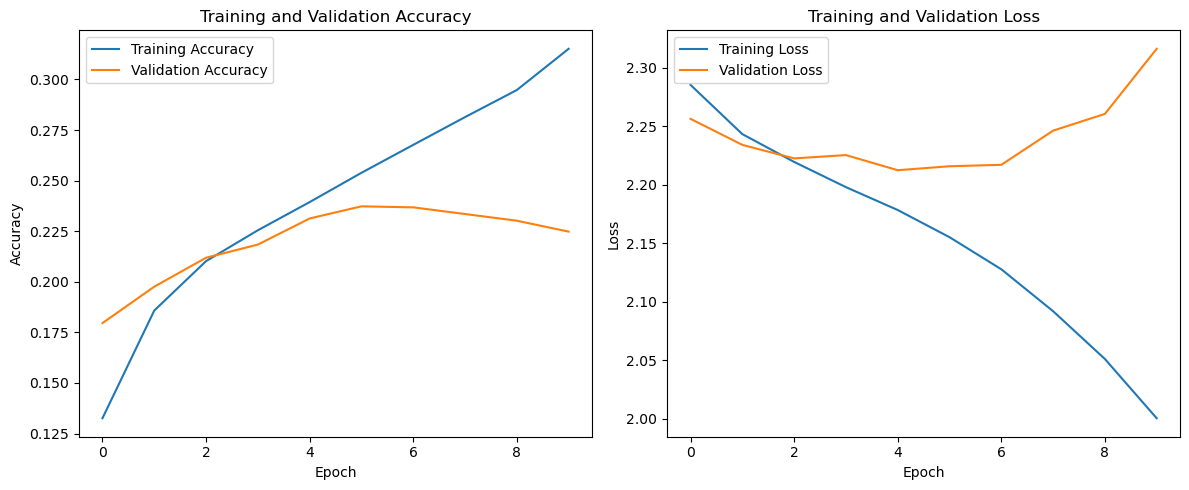

In [20]:
# Accuracy and Loss graph for Model I
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

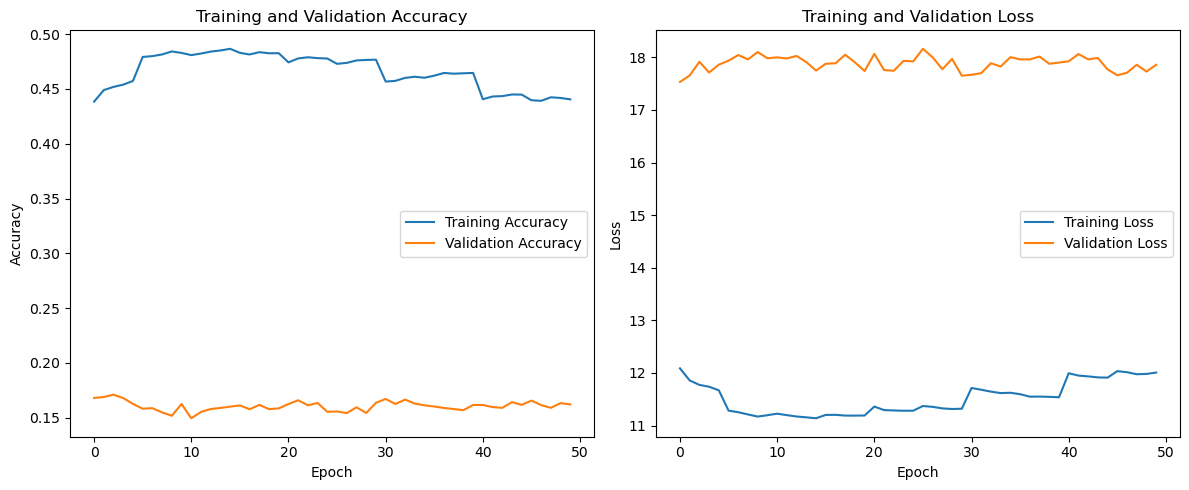

In [21]:
# Accuracy and Loss graph for Model II
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(new_train_acc, label='Training Accuracy')
plt.plot(new_val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(new_train_loss, label='Training Loss')
plt.plot(new_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Output label predicted by three models
label = test_labels[1:]
baseline = []
for image in test_imgs:
    baseline.append(baseline_model(image))
modelI = np.argmax(cnn_model.predict(test_imgs,verbose=0),1)
modelII = np.argmax(new_cnn_model.predict(test_imgs,verbose=0),1)

label_prediction = pd.DataFrame(zip(label, baseline, modelI ,modelII),
                                columns = ['Labels','Baseline','Model I','Model II'])
label_prediction.to_csv('label_prediction.csv', index=True)